In [1]:
from astropy.table import Table, vstack, Column
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import astropy.units as u
from IPython.display import display, Math
import seaborn as sns

In [11]:
model_raw = Table.read('GalfitM_DECALS_SPLUS_ahorasi.csv', format='ascii')
splus_raw = Table.read('Galfitm_SPLUS_ahorasi_2.csv', format='ascii')
#splus_raw = Table.read('galfitm_splus_234.csv', format='ascii')
splus = splus_raw[splus_raw['type'] != 'PSF']
model = model_raw[model_raw['type'] != 'PSF'] 
model_splus_raw = Table.read('splus_and_decals.csv', format='ascii')
model_splus = model_splus_raw[model_splus_raw['type_1'] != 'PSF']
m = model.group_by('Group')

s = splus.group_by('Group')
keys = s.groups.keys
keys_model = m.groups.keys

#model = model[model['mag_r'] < 18]
#splus = splus[splus['MAG_r'] < 18]

#splus = splus[(splus['MAG_g'] < 18.5) & (splus['MAG_r'] < 18.5) & (splus['MAG_i'] < 18.5) & (splus['MAG_z'] < 18.5)]
#model = model[(model['mag_g'] < 18.5) & (model['mag_r'] < 18.5) & (model['mag_i'] < 18.5) & (model['mag_z'] < 18.5)]

# Encontrar las combinaciones únicas de 'Group' y 'Gal' en ambos catálogos
keys_splus = set(zip(splus['ra'], splus['dec']))
keys_model = set(zip(model['ra'], model['dec']))

# Filtrar 'model' para que solo conserve las combinaciones comunes de 'Group' y 'Gal'
common_keys = keys_splus.intersection(keys_model)
model_filtered = model[[tuple(row['ra', 'dec']) in common_keys for row in model]]
splus_filtered = splus[[tuple(row['ra', 'dec']) in common_keys for row in splus]]

# Resultado final
print(f"Total de galaxias en 'model' y 'splus' tras el filtrado: {len(model_filtered)}, {len(splus_filtered)}")
#print(len(model_splus))

Total de galaxias en 'model' y 'splus' tras el filtrado: 101, 101


In [3]:
splus_filtered['n_i']

0.7938
0.4790
1.0894
1.9746
1.6434
1.8305
1.4286
1.8554
0.7048
0.4759
1.1078


In [4]:
# Mostrar los nombres de las columnas antes del cambio
#print("Nombres de columnas antes del cambio:", splus.colnames)

# Definir las columnas que deseas cambiar
#columnas_a_cambiar = ['n_R', 'n_G', 'n_I', 'n_Z', 'RE_R', 'RE_G', 'RE_I', 'RE_Z', 'MAG_R', 'MAG_G', 'MAG_I', 'MAG_Z', 'e_n_R', 'e_n_G', 'e_n_I', 'e_n_Z', 'e_RE_R', 'e_RE_G', 'e_RE_I', 'e_RE_Z', 'e_MAG_R', 'e_MAG_G', 'e_MAG_I', 'e_MAG_Z']

# Crear un diccionario para mapear los nombres antiguos a los nuevos solo para las columnas específicas
#column_mapping = {col: re.sub(r'_(G|R|I|Z)', lambda x: f'_{x.group(1).lower()}', col) for col in columnas_a_cambiar}

# Renombrar las columnas en la tabla
#for old_name, new_name in column_mapping.items():
#    if old_name in splus.colnames:
#        splus.rename_column(old_name, new_name)
#print(splus.colnames)

In [5]:
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])

    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)
    return final_table

In [12]:
filtros = ['g', 'r', 'i', 'z']
filtros_splus_filtered = ['u', 'J0378', 'J0395', 'J0410', 'J0430', 'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z']
for filtro in filtros:        
    model_filtered['n_' + filtro] = pd.to_numeric(model_filtered['n_' + filtro], errors='coerce')
    model_filtered['RE_' +filtro] = pd.to_numeric(model_filtered['RE_' + filtro], errors = 'coerce')*0.262
    model_filtered['e_n_' + filtro] = pd.to_numeric(model_filtered['e_n_' + filtro], errors='coerce')
    model_filtered['e_RE_' + filtro] = pd.to_numeric(model_filtered['e_RE_' + filtro], errors='coerce')*0.262
    model_splus[f'n_{filtro}_1'] = pd.to_numeric(model_splus[f'n_{filtro}_1'], errors='coerce')
    model_splus[f'RE_{filtro}_1'] = pd.to_numeric(model_splus[f'RE_{filtro}_1'], errors = 'coerce')*0.55
    model_splus[f'e_n_{filtro}_1'] = pd.to_numeric(model_splus[f'e_n_{filtro}_1'], errors='coerce')
    model_splus[f'e_RE_{filtro}_1'] = pd.to_numeric(model_splus[f'e_RE_{filtro}_1'], errors='coerce')*0.55
    model_splus[f'n_{filtro}_2'] = pd.to_numeric(model_splus[f'n_{filtro}_2'], errors='coerce')
    model_splus[f'RE_{filtro}_2'] = pd.to_numeric(model_splus[f'RE_{filtro}_2'], errors = 'coerce')*0.262
    model_splus[f'e_n_{filtro}_2'] = pd.to_numeric(model_splus[f'e_n_{filtro}_2'], errors='coerce')
    model_splus[f'e_RE_{filtro}_2'] = pd.to_numeric(model_splus[f'e_RE_{filtro}_2'], errors='coerce')*0.262
#H_0 = 67.4  # km/s/Mpc
#splus_filtered['Distance (Mpc)'] = (splus_filtered['zmemb'] * 300000) / H_0
for fil in filtros_splus_filtered:
    splus_filtered['n_' + fil] = pd.to_numeric(splus_filtered['n_' + fil], errors='coerce')
    splus_filtered['RE_' +fil] = pd.to_numeric(splus_filtered['RE_' + fil], errors = 'coerce')*0.55
    splus_filtered['MAG_' +fil] = pd.to_numeric(splus_filtered['MAG_' + fil], errors = 'coerce')
    splus_filtered['e_n_' + fil] = pd.to_numeric(splus_filtered['e_n_' + fil], errors='coerce')
    splus_filtered['e_RE_' + fil] = pd.to_numeric(splus_filtered['e_RE_' + fil], errors='coerce')*0.55
    #splus_filtered[f'RE_{fil}(kpc)'] = (splus_filtered[f'RE_{fil}'] * 0.55 * splus_filtered['Distance (Mpc)']) / 206.265
    #splus_filtered[f'e_RE_{fil}(kpc)'] = (splus_filtered[f'e_RE_{fil}'] * 0.55 * splus_filtered['Distance (Mpc)']) / 206.265


In [8]:
model_filtered

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,ebv,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,Group_2,Gal_2,zmemb
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
20,1,1471,13.04012577583562,-1.119177251059751,SER,0.550881294713299,756.9186,0.002,659.4763,0.0047,8.9852638,0.004034800000000001,16.5489,0.0005,0.7657,0.0009,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,8.6112064,0.0030391999999999997,15.8441,0.0003,0.9628,0.0006,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,8.25431,0.0035108,15.5299,0.0003,1.1508,0.0007,0.2277,0.0001,-23.0521,0.0058,756.9186,0.002,659.4763,0.0047,7.8679386000000004,0.005109,15.2787,0.0005,1.3544,0.0013,0.2277,0.0001,-23.0521,0.0058,324660,0131m010,1471,0.051570516,16.592842,15.869571,15.490888,15.243752,15.001912,15.345359,13.093337,12.205332,20,1,0.041238
20,4,1904,13.05099114252429,-1.111288683922806,SER,0.550881294713299,607.4764,0.0036,767.6451,0.0014,3.9911508,0.003406,17.4378,0.0008,0.953,0.0019,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,3.8174972000000005,0.0021746,16.8177,0.0005,1.0009,0.0011,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,3.6518084,0.0023056,16.5724,0.0005,1.0466,0.0013,0.2954,0.0001,78.0638,0.0124,607.4764,0.0036,767.6451,0.0014,3.4724694,0.0037466,16.3689,0.0009,1.0961,0.0022,0.2954,0.0001,78.0638,0.0124,324660,0131m010,1904,0.05183192,17.467215,16.829493,16.518545,16.326435,16.46787,16.92776,14.921985,13.97155,20,4,0.0413
26,4,7828,16.84741713183292,-32.8290673708472,SER,0.793480348577686,430.8808,0.0004,765.8698,0.0008,3.5662392,0.0009694,15.9679,0.0002,1.2265,0.0009,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,3.2166526,0.0006288,15.0434,0.0001,1.3947,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,2.8831266,0.0005502,14.7278,0.0001,1.5551,0.0006,0.3725,0.0001,16.5187,0.0053,430.8808,0.0004,765.8698,0.0008,2.5220644,0.0008646,14.4175,0.0002,1.7287,0.001,0.3725,0.0001,16.5187,0.0053,151766,0167m327,7828,0.028982436,15.957093,15.089968,14.717459,14.474657,14.970778,15.49166,15.527465,--,26,4,0.035811
26,1,6445,16.80270840320432,-32.83567747715625,REX,0.793480348577686,946.9052,0.0086,674.7876,0.0092,4.3242838,0.0075194,17.7552,0.0016,0.9076,0.0025,0.9179,0.0007,6.0506,0.496,946.9052,0.0086,674.7876,0.0092,4.2742942,0.005475799999999999,17.2521,0.0013,1.0749,0.0018,0.9179,0.0007,6.0506,0.496,946.9052,0.0086,674.7876,0.0092,4.2266102000000005,0.008908000000000001,17.0555,0.002,1.2345,0.003,0.9179,0.0007,6.0506,0.496,946.9052,0.0086,674.7876,0.0092,4.1749962,0.0146458,16.9425,0.0032,1.4073,0.0051,0.9179,0.0007,6.0506,0.496,151766,0167m327,6445,0.029552748,17.834425,17.320929,17.108545,16.967478,17.419529,18.017485,18.834425,--,26,1,0.0643
28,4,10387,20.29108124601455,-32.04061563232854,SER,0.617147559253985,401.5528,0.0027,856.7382,0.004,4.584449800000001,0.0047946,17.048,0.0009,1.2767,0.0019,0.6056,0.0003,13.1909,0.0406,401.5528,0.0027,856.7382,0.004,4.468148,0.002882,16.5993,0.0006,1.3601,0.0011,0.6056,0.0003,13.1909,0.0406,401.5528,0.0027,856.7382,0.004,4.357217200000001,0.0039562,

In [9]:
model_splus['dif'] = model_splus['n_r_1'] - model_splus['n_r_2']
model_splus['dif_re'] = model_splus['RE_r_1'] - model_splus['RE_r_2']

dif_n = model_splus[abs(model_splus['dif']) > 1]
#print(dif_n['Gal_1'], dif_n['Gal_2a'])
dif_n

X,Y,ELONGATION,ELLIPTICITY,THETA,A,B,FLUX_RADIUS_50,FLUX_RADIUS_90,u_auto,e_u_auto,SEX_FLAGS_u,J0378_auto,e_J0378_auto,SEX_FLAGS_J0378,J0395_auto,e_J0395_auto,SEX_FLAGS_J0395,J0410_auto,e_J0410_auto,SEX_FLAGS_J0410,J0430_auto,e_J0430_auto,SEX_FLAGS_J0430,g_auto,e_g_auto,SEX_FLAGS_g,J0515_auto,e_J0515_auto,SEX_FLAGS_J0515,r_auto,e_r_auto,SEX_FLAGS_r,J0660_auto,e_J0660_auto,SEX_FLAGS_J0660,i_auto,e_i_auto,SEX_FLAGS_i,J0861_auto,e_J0861_auto,SEX_FLAGS_J0861,z_auto,e_z_auto,SEX_FLAGS_z,zml,odds,_RAJ2000,_DEJ2000,Group_1,Gal_1,RAJ2000,DEJ2000,zmemb_1,gmemb,FUV,NUV,Simbad,CHI2NU_1,XC_r_1,e_XC_r_1,YC_r_1,e_YC_r_1,MAG_r_1,e_MAG_r_1,RE_r_1,e_RE_r_1,n_r_1,e_n_r_1,AR_r_1,e_AR_r_1,PA_r_1,e_PA_r_1,XC_J0378,e_XC_J0378,YC_J0378,e_YC_J0378,MAG_J0378,e_MAG_J0378,RE_J0378,e_RE_J0378,n_J0378,e_n_J0378,AR_J0378,e_AR_J0378,PA_J0378,e_PA_J0378,XC_J0395,e_XC_J0395,YC_J0395,e_YC_J0395,MAG_J0395,e_MAG_J0395,RE_J0395,e_RE_J0395,n_J0395,e_n_J0395,AR_J0395,e_AR_J0395,PA_J0395,e_PA_J0395,XC_J0410,e_XC_J0410,YC_J0410,e_YC_J0410,MAG_J0410,e_MAG_J0410,RE_J0410,e_RE_J0410,n_J0410,e_n_J0410,AR_J0410,e_AR_J0410,PA_J0410,e_PA_J0410,XC_J0430,e_XC_J0430,YC_J0430,e_YC_J0430,MAG_J0430,e_MAG_J0430,RE_J0430,e_RE_J0430,n_J0430,e_n_J0430,AR_J0430,e_AR_J0430,PA_J0430,e_PA_J0430,XC_J0515,e_XC_J0515,YC_J0515,e_YC_J0515,MAG_J0515,e_MAG_J0515,RE_J0515,e_RE_J0515,n_J0515,e_n_J0515,AR_J0515,e_AR_J0515,PA_J0515,e_PA_J0515,XC_J0660,e_XC_J0660,YC_J0660,e_YC_J0660,MAG_J0660,e_MAG_J0660,RE_J0660,e_RE_J0660,n_J0660,e_n_J0660,AR_J0660,e_AR_J0660,PA_J0660,e_PA_J0660,XC_J0861,e_XC_J0861,YC_J0861,e_YC_J0861,MAG_J0861,e_MAG_J0861,RE_J0861,e_RE_J0861,n_J0861,e_n_J0861,AR_J0861,e_AR_J0861,PA_J0861,e_PA_J0861,XC_g_1,e_XC_g_1,YC_g_1,e_YC_g_1,MAG_g_1,e_MAG_g_1,RE_g_1,e_RE_g_1,n_g_1,e_n_g_1,AR_g_1,e_AR_g_1,PA_g_1,e_PA_g_1,XC_i_1,e_XC_i_1,YC_i_1,e_YC_i_1,MAG_i_1,e_MAG_i_1,RE_i_1,e_RE_i_1,n_i_1,e_n_i_1,AR_i_1,e_AR_i_1,PA_i_1,e_PA_i_1,XC_z_1,e_XC_z_1,YC_z_1,e_YC_z_1,MAG_z_1,e_MAG_z_1,RE_z_1,e_RE_z_1,n_z_1,e_n_z_1,AR_z_1,e_AR_z_1,PA_z_1,e_PA_z_1,XC_u,e_XC_u,YC_u,e_YC_u,MAG_u,e_MAG_u,RE_u,e_RE_u,n_u,e_n_u,AR_u,e_AR_u,PA_u,e_PA_u,ra_1,dec_1,type_1,Group_2a,Gal_2a,ID,ra_2,dec_2,type_2,CHI2NU_2,XC_g_2,e_XC_g_2,YC_g_2,e_YC_g_2,RE_g_2,e_RE_g_2,MAG_g_2,e_MAG_g_2,n_g_2,e_n_g_2,AR_g_2,e_AR_g_2,PA_g_2,e_PA_g_2,XC_r_2,e_XC_r_2,YC_r_2,e_YC_r_2,RE_r_2,e_RE_r_2,MAG_r_2,e_MAG_r_2,n_r_2,e_n_r_2,AR_r_2,e_AR_r_2,PA_r_2,e_PA_r_2,XC_i_2,e_XC_i_2,YC_i_2,e_YC_i_2,RE_i_2,e_RE_i_2,MAG_i_2,e_MAG_i_2,n_i_2,e_n_i_2,AR_i_2,e_AR_i_2,PA_i_2,e_PA_i_2,XC_z_2,e_XC_z_2,YC_z_2,e_YC_z_2,RE_z_2,e_RE_z_2,MAG_z_2,e_MAG_z_2,n_z_2,e_n_z_2,AR_z_2,e_AR_z_2,PA_z_2,e_PA_z_2,brickid,brickname,objid,ebv,mag_g_2a,mag_r_2a,mag_i_2a,mag_z_2a,mag_w1,mag_w2,mag_w3,mag_w4,Group_2,Gal_2,zmemb_2,Separation,dif,dif_re
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,str10,str8,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,str9,str8,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,str9,str8,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,fl

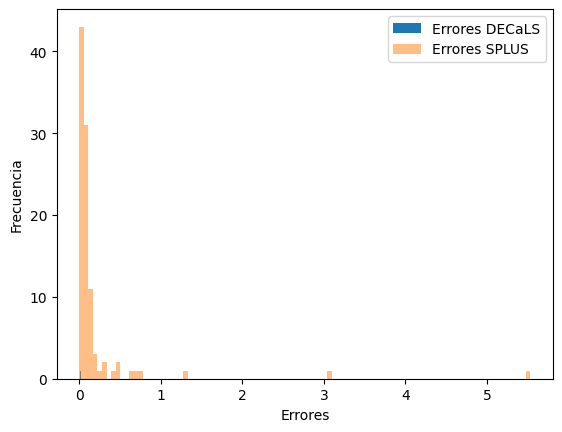

In [4]:
# Filtrar los NaN de los errores
errores_g_decals = model_filtered['e_RE_g']
errores_g_splus = splus_filtered['e_RE_g']

errores_filtrados_decals = errores_g_decals[(~np.isnan(errores_g_decals)) & (errores_g_decals != 0.0)]
errores_filtrados_splus = errores_g_splus[(~np.isnan(errores_g_splus)) & (errores_g_splus != 0.0)]

# Crear el histograma
plt.hist(errores_filtrados_decals, alpha=1, bins=100, label='Errores DECaLS')
plt.hist(errores_filtrados_splus, alpha=0.5, bins=100, label='Errores SPLUS')

# Ajustar los límites del eje x
#plt.xlim(0, 1)

# Etiquetas y leyenda
plt.xlabel('Errores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

In [42]:
model_group_234 = model_filtered[model_filtered['Group'] == 235]
splus_group_234 = splus_filtered[splus_filtered['Group'] == 235]
splus_group_234.sort('Gal')
splus_group_234

Group,Gal,ID,CHI2NU,XC_R,e_XC_R,YC_R,e_YC_R,MAG_r,e_MAG_r,RE_r,e_RE_r,n_r,e_n_r,AR_R,e_AR_R,PA_R,e_PA_R,XC_J0378,e_XC_J0378,YC_J0378,e_YC_J0378,MAG_J0378,e_MAG_J0378,RE_J0378,e_RE_J0378,n_J0378,e_n_J0378,AR_J0378,e_AR_J0378,PA_J0378,e_PA_J0378,XC_J0395,e_XC_J0395,YC_J0395,e_YC_J0395,MAG_J0395,e_MAG_J0395,RE_J0395,e_RE_J0395,n_J0395,e_n_J0395,AR_J0395,e_AR_J0395,PA_J0395,e_PA_J0395,XC_J0410,e_XC_J0410,YC_J0410,e_YC_J0410,MAG_J0410,e_MAG_J0410,RE_J0410,e_RE_J0410,n_J0410,e_n_J0410,AR_J0410,e_AR_J0410,PA_J0410,e_PA_J0410,XC_J0430,e_XC_J0430,YC_J0430,e_YC_J0430,MAG_J0430,e_MAG_J0430,RE_J0430,e_RE_J0430,n_J0430,e_n_J0430,AR_J0430,e_AR_J0430,PA_J0430,e_PA_J0430,XC_J0515,e_XC_J0515,YC_J0515,e_YC_J0515,MAG_J0515,e_MAG_J0515,RE_J0515,e_RE_J0515,n_J0515,e_n_J0515,AR_J0515,e_AR_J0515,PA_J0515,e_PA_J0515,XC_J0660,e_XC_J0660,YC_J0660,e_YC_J0660,MAG_J0660,e_MAG_J0660,RE_J0660,e_RE_J0660,n_J0660,e_n_J0660,AR_J0660,e_AR_J0660,PA_J0660,e_PA_J0660,XC_J0861,e_XC_J0861,YC_J0861,e_YC_J0861,MAG_J0861,e_MAG_J0861,RE_J0861,e_RE_J0861,n_J0861,e_n_J0861,AR_J0861,e_AR_J0861,PA_J0861,e_PA_J0861,XC_G,e_XC_G,YC_G,e_YC_G,MAG_g,e_MAG_g,RE_g,e_RE_g,n_g,e_n_g,AR_G,e_AR_G,PA_G,e_PA_G,XC_I,e_XC_I,YC_I,e_YC_I,MAG_i,e_MAG_i,RE_i,e_RE_i,n_i,e_n_i,AR_I,e_AR_I,PA_I,e_PA_I,XC_Z,e_XC_Z,YC_Z,e_YC_Z,MAG_z,e_MAG_z,RE_z,e_RE_z,n_z,e_n_z,AR_Z,e_AR_Z,PA_Z,e_PA_Z,XC_U,e_XC_U,YC_U,e_YC_U,MAG_u,e_MAG_u,RE_u,e_RE_u,n_u,e_n_u,AR_U,e_AR_U,PA_U,e_PA_U,Field,RA,DEC,X,Y,ELONGATION,ELLIPTICITY,THETA,A,B,FLUX_RADIUS_50,FLUX_RADIUS_90,u_auto,e_u_auto,SEX_FLAGS_u,J0378_auto,e_J0378_auto,SEX_FLAGS_J0378,J0395_auto,e_J0395_auto,SEX_FLAGS_J0395,J0410_auto,e_J0410_auto,SEX_FLAGS_J0410,J0430_auto,e_J0430_auto,SEX_FLAGS_J0430,g_auto,e_g_auto,SEX_FLAGS_g,J0515_auto,e_J0515_auto,SEX_FLAGS_J0515,r_auto,e_r_auto,SEX_FLAGS_r,J0660_auto,e_J0660_auto,SEX_FLAGS_J0660,i_auto,e_i_auto,SEX_FLAGS_i,J0861_auto,e_J0861_auto,SEX_FLAGS_J0861,z_auto,e_z_auto,SEX_FLAGS_z,zml,odds,zmemb,gmemb,FUV,NUV,objid,type,ra,dec,ebv
int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,str3,float64,float64,float64
235,1,iDR4_3_SPLUS-s38s34_0025398,1.50640417478314,358.3094,0.0245,270.9578,0.0258,16.7407,0.0164,3.0793950000000003,0.04048,1.2283,0.0195,0.9323,0.0083,0.006039,5.446,358.3094,0.0245,270.9578,0.0258,17.7473,0.0776,3.085995,0.09592,0.9921,0.0582,0.9323,0.0083,0.006039,5.446,358.3094,0.

In [43]:
model_group_234.sort('Gal')
model_group_234

Group,Gal,ID,ra,dec,type,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,ebv,mag_g,mag_r,mag_i,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,Group_2,Gal_2,zmemb
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
235,1,6575,66.71578600950266,-49.11614529629508,REX,2.02397369168898,913.7439,0.0042,732.6036,0.0045,2.9297888,0.004034800000000001,16.9969,0.0012,1.0916,0.0024,0.9483,0.0007,5.4123,0.5946,913.7439,0.0042,732.6036,0.0045,2.9052918,0.0026462,16.6266,0.0008,1.2309,0.0015,0.9483,0.0007,5.4123,0.5946,913.7439,0.0042,732.6036,0.0045,2.8819214000000004,0.0044016,16.476,0.0014,1.3639,0.0026,0.9483,0.0007,5.4123,0.5946,913.7439,0.0042,732.6036,0.0045,2.8566122000000003,0.0074932,16.3962,0.0022,1.5078,0.0045,0.9483,0.0007,5.4123,0.5946,81279,0666m490,6575,0.02021754,17.078983,16.700003,16.501606,16.463678,16.765846,17.158281,14.911572,13.767239,235,1,0.0
235,2,6922,66.72834628857257,-49.1176649251292,SER,2.02397369168898,801.1431,0.0159,711.9068,0.0123,3.4369946000000002,0.030889800000000002,18.6302,0.0068,1.8101,0.019,0.6933,0.0023,-86.7231,0.3817,801.1431,0.0159,711.9068,0.0123,3.3156886,0.0182614,18.3628,0.0044,1.8449,0.0112,0.6933,0.0023,-86.7231,0.3817,801.1431,0.0159,711.9068,0.0123,3.1999370000000003,0.030392000000000002,18.2575,0.008,1.8781,0.0194,0.6933,0.0023,-86.7231,0.3817,801.1431,0.0159,711.9068,0.0123,3.0746486,0.053500400000000004,18.244,0.0138,1.914,0.0343,0.6933,0.0023,-86.7231,0.3817,81279,0666m490,6922,0.02005361,18.373566,18.072979,17.95097,17.898602,--,--,--,--,235,2,0.0
235,3,10927,66.73140597687143,-49.12506145178234,SER,2.02397369168898,773.578,0.003,610.4316,0.0024,3.2775152000000003,0.009615400000000001,16.9043,0.0018,2.8768,0.0081,0.6732,0.0007,-66.2668,0.0913,773.578,0.003,610.4316,0.0024,3.5387030000000004,0.0066286,16.5169,0.0012,3.0526,0.0051,0.6732,0.0007,-66.2668,0.0913,773.578,0.003,610.4316,0.0024,3.7878912,0.0118686,16.3004,0.002,3.2204,0.0075,0.6732,0.0007,-66.2668,0.0913,773.578,0.003,610.4316,0.0024,4.0576726,0.020095400000000003,16.1452,0.0029,3.402,0.0129,0.6732,0.0007,-66.2668,0.0913,80334,0665m492,10927,0.020014493,16.603977,16.250761,16.09803,15.989478,16.49382,16.894287,15.411119,13.404518,235,3,0.0
235,4,10060,66.75788923904496,-49.1245573541696,DUP,2.02397369168898,535.3642,0.0012,617.0504,0.0014,7.324681600000001,0.020069200000000002,15.7577,0.0014,4.9827,0.0093,0.6726,0.0003,10.1233,0.0391,535.3642,0.0012,617.0504,0.0014,6.7254876,0.0129428,14.9043,0.001,4.9662,0.006,0.6726,0.0003,10.1233,0.0391,535.3642,0.0012,617.0504,0.0014,6.1538036,0.0115542,14.5619,0.001,4.9504,0.0058,0.6726,0.0003,10.1233,0.0391,535.3642,0.0012,617.0504,0.0014,5.5349334,0.0174754,14.3542,0.0016,4.9333,0.009,0.6726,0.0003,10.1233,0.0391,81279,0666m490,10060,0.019797854,inf,inf,inf,inf,inf,inf,inf,inf,235,4,0.0
235,5,8148,66.77262982968402,-49.11473712347369,SER,2.02397369168898,407.1009,0.0016,749.3088,0.0008,3.7582066000000003,0.002358,15.5293,0.0004,2.0111,0.0016,0.4783,0.0001,77.02,0.013,407.1009,0.0016,749.3088,0.0008,3.7849568000000002,0.001441,14.872,0.0003,1.9171,0.0009,0.4783,0.0001,77.02,0.013,407.1009,0.0016,749.3088,0.0008,3.8104494,0.0017292,14.678,0.

[[1.0916 1.8101 2.8768 4.9827 2.0111]
 [1.2309 1.8449 3.0526 4.9662 1.9171]
 [1.3639 1.8781 3.2204 4.9504 1.8274]
 [1.5078 1.914  3.402  4.9333 1.7303]] [[1.0852 1.652  2.6062 5.2323 1.2828]
 [1.2283 1.706  3.0088 5.2952 1.202 ]
 [1.3642 1.7573 3.3914 5.3549 1.1252]
 [1.4726 1.7982 3.6962 5.4025 1.0641]]


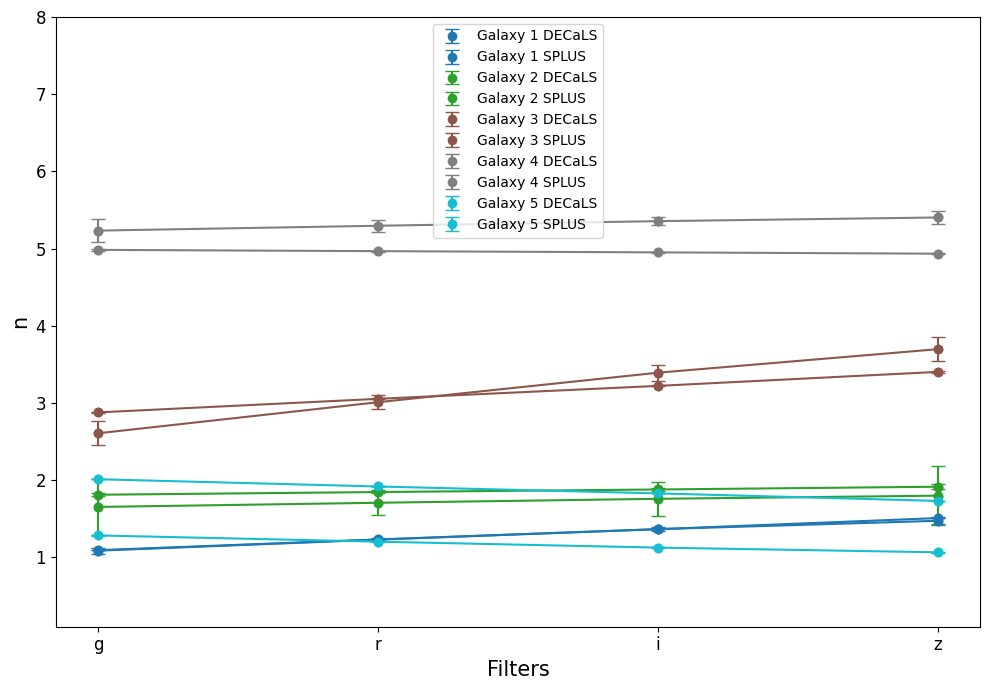

In [44]:
# Supongamos que 'Gal' contiene los números de las galaxias en las tablas
galaxias = model_group_234['Gal']  # Asegúrate de que esta columna exista
colores = plt.cm.tab10(np.linspace(0, 1, len(galaxias)))  

valores_sersic_234 = np.array([model_group_234['n_' + filtro] for filtro in filtros])
valores_sersic_234_splus = np.array([splus_group_234['n_'+filtro] for filtro in filtros])

errores_sersic_234 = np.array([model_group_234['e_n_' + filtro] for filtro in filtros])
errores_sersic_234_splus = np.array([splus_group_234['e_n_' + filtro] for filtro in filtros])

print(valores_sersic_234, valores_sersic_234_splus)

# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))
for i, gal in enumerate(galaxias):
    color = colores[i]
    # Gráfico para valores_sersic con barras de error
    plt.errorbar(filtros, valores_sersic_234[:, i], yerr=errores_sersic_234[:, i], fmt='o', capsize=5, color=color, label=f'Galaxy {gal} DECaLS')
    plt.plot(filtros, valores_sersic_234[:, i], color=color, linestyle='-', marker='o')

    # Gráfico para valores_sersic_splus con barras de error
    plt.errorbar(filtros, valores_sersic_234_splus[:, i], yerr=errores_sersic_234_splus[:, i], fmt='o', capsize=5, color=color, label=f'Galaxy {gal} SPLUS')
    plt.plot(filtros, valores_sersic_234_splus[:, i], color=color, linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)# Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('n', size=15)
#plt.title('Magnitude limited sample', size=15)
plt.legend()
plt.ylim(0.1, 8)


plt.tight_layout()

# Mostrar el gráfico
plt.show()

[[2.9297888 3.4369946 3.2775152 7.3246816 3.7582066]
 [2.9052918 3.3156886 3.538703  6.7254876 3.7849568]
 [2.8819214 3.199937  3.7878912 6.1538036 3.8104494]
 [2.8566122 3.0746486 4.0576726 5.5349334 3.8380904]] [[3.08341  3.340535 3.16173  8.492495 4.951155]
 [3.079395 2.992495 3.593755 8.3996   4.945875]
 [3.075655 2.66178  4.004275 8.311325 4.94087 ]
 [3.07263  2.398275 4.331415 8.241035 4.936855]]


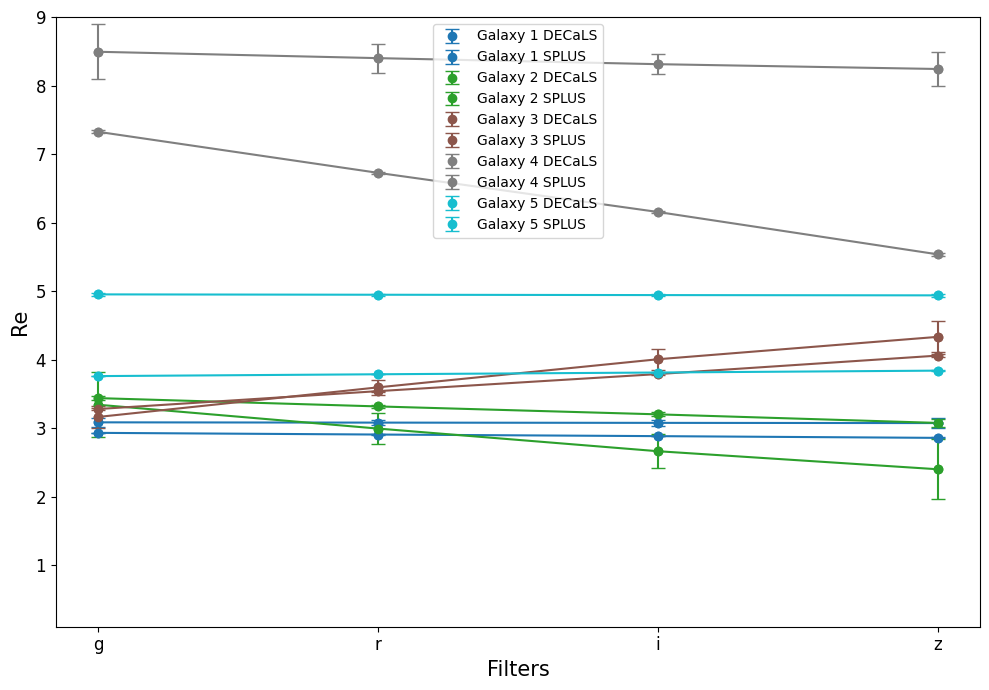

In [47]:
# Supongamos que 'Gal' contiene los números de las galaxias en las tablas
galaxias = model_group_234['Gal']  # Asegúrate de que esta columna exista
colores = plt.cm.tab10(np.linspace(0, 1, len(galaxias)))  

valores_sersic_234 = np.array([model_group_234['RE_' + filtro] for filtro in filtros])
valores_sersic_234_splus = np.array([splus_group_234['RE_'+filtro] for filtro in filtros])

errores_sersic_234 = np.array([model_group_234['e_RE_' + filtro] for filtro in filtros])
errores_sersic_234_splus = np.array([splus_group_234['e_RE_' + filtro] for filtro in filtros])

print(valores_sersic_234, valores_sersic_234_splus)

# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))
for i, gal in enumerate(galaxias):
    color = colores[i]
    # Gráfico para valores_sersic con barras de error
    plt.errorbar(filtros, valores_sersic_234[:, i], yerr=errores_sersic_234[:, i], fmt='o', capsize=5, color=color, label=f'Galaxy {gal} DECaLS')
    plt.plot(filtros, valores_sersic_234[:, i], color=color, linestyle='-', marker='o')

    # Gráfico para valores_sersic_splus con barras de error
    plt.errorbar(filtros, valores_sersic_234_splus[:, i], yerr=errores_sersic_234_splus[:, i], fmt='o', capsize=5, color=color, label=f'Galaxy {gal} SPLUS')
    plt.plot(filtros, valores_sersic_234_splus[:, i], color=color, linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)# Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('Re', size=15)
#plt.title('Magnitude limited sample', size=15)
plt.legend()
plt.ylim(0.1, 9)


plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [14]:
valores_sersic = np.array([model_filtered['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus_filtered['n_'+filtro] for filtro in filtros])

errores_sersic = np.array([model_filtered['e_n_' + filtro] for filtro in filtros])
errores_sersic_splus = np.array([splus_filtered['e_n_' + filtro] for filtro in filtros])

# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Convertir a valores numéricos, forzando coerción
    valores = pd.to_numeric(valores, errors='coerce')
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    print(len(valores_filtrados))
    if len(valores_filtrados) > 0:
        return np.nanmedian(valores_filtrados)
    else:
        print('NO HAY VALORES QUE CALCULAR')
        return np.nan
def calcular_errores(valores):
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    if len(valores_filtrados) > 0:
        error = np.nanmedian(valores_filtrados)
        return error

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_sersic = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_sersic_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic_splus[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic'
error_valores_sersic = np.array([calcular_errores(errores_sersic[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic_splus'
error_valores_sersic_splus = np.array([calcular_errores(errores_sersic_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(f'{medianas_valores_sersic} $\pm$ {error_valores_sersic}')

print("\nMedianas para valores_sersic_splus:")
print(f'{medianas_valores_sersic_splus} $\pm$ {error_valores_sersic_splus}')

54
54
54
51
53
54
54
54
Medianas para valores_sersic:
[0.9131 1.1301 1.2941 1.4249] $\pm$ [0.00175 0.0011  0.00155 0.0025 ]

Medianas para valores_sersic_splus:
[0.9809  1.23995 1.41845 1.57585] $\pm$ [0.0255  0.0166  0.02285 0.0375 ]


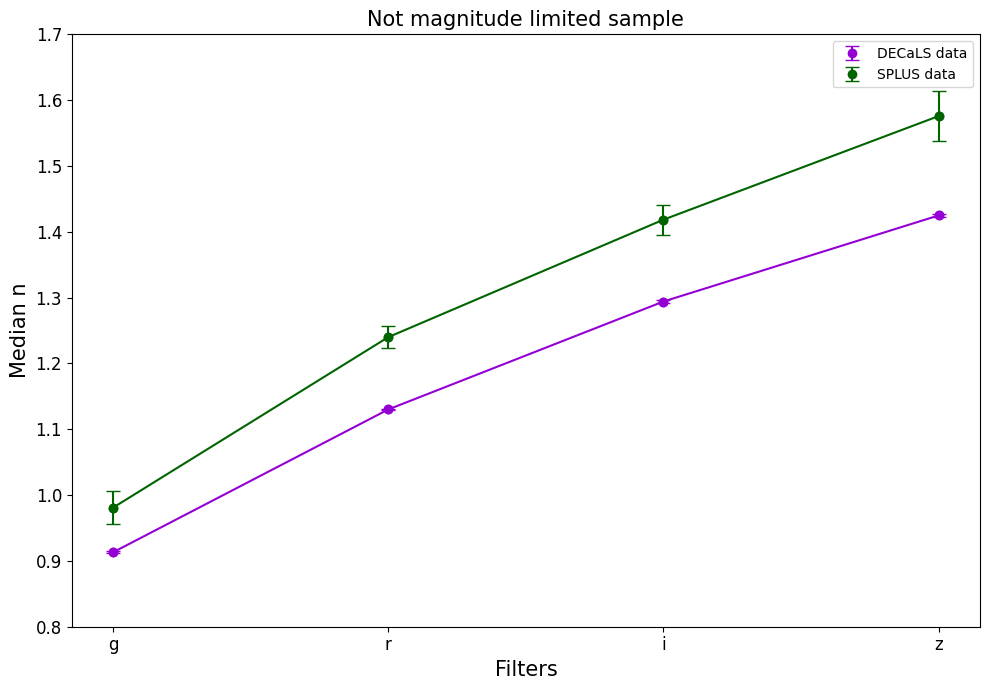

In [15]:
# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))

# Gráfico para valores_sersic con barras de error
plt.errorbar(filtros, medianas_valores_sersic, yerr=error_valores_sersic, fmt='o', capsize=5, color='darkviolet', label='DECaLS data')
plt.plot(filtros, medianas_valores_sersic, color='darkviolet', linestyle='-', marker='o')

# Gráfico para valores_sersic_splus con barras de error
plt.errorbar(filtros, medianas_valores_sersic_splus, yerr=error_valores_sersic_splus, fmt='o', capsize=5, color='darkgreen', label='SPLUS data')
plt.plot(filtros, medianas_valores_sersic_splus, color='darkgreen', linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)# Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('Median n', size=15)
plt.title('Not magnitude limited sample', size=15)
plt.legend()
plt.ylim(0.8, 1.7)


plt.tight_layout()

# Mostrar el gráfico
plt.show()

La mediana de la diferencias en n: -0.0844, con mínimo en -2.5058, y máximo 2.9647
La mediana de la diferencias en n: -0.0873, con mínimo en -8.169, y máximo 2.7891
La mediana de la diferencias en n: -0.1874, con mínimo en -6.4474, y máximo 3.7153
La mediana de la diferencias en n: -0.2683, con mínimo en -4.9223, y máximo 4.7755


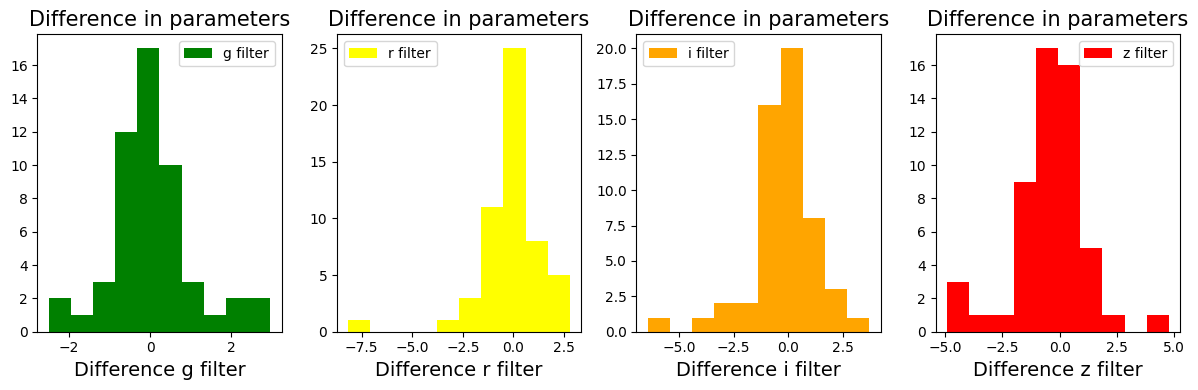

In [16]:
# Función para graficar Re vs n en grz.
def graficar_diferencias(axs, valores, valores_s, color_g, color_r, color_i, color_z, parameter):
    
    dif_g = valores[0] - valores_s[0]
    dif_r = valores[1] - valores_s[1]
    dif_i = valores[2] - valores_s[2]
    dif_z = valores[3] - valores_s[3]

    
    axs[0].hist(dif_g, density = False, bins=10, label='g filter', color=color_g)
    axs[0].set_xlabel('Difference g filter', fontsize = 14)
    axs[0].set_title(f'Difference in parameters', fontsize=15)

    axs[1].hist(dif_r, density = False, bins=10, label='r filter', color=color_r)
    axs[1].set_xlabel('Difference r filter', fontsize = 14)
    axs[1].set_title(f'Difference in parameters', fontsize=15)

    axs[2].hist(dif_i, density = False, bins=10, label='i filter', color=color_i)
    axs[2].set_xlabel('Difference i filter', fontsize = 14)
    axs[2].set_title(f'Difference in parameters', fontsize=15)
    
    axs[3].hist(dif_z, density = False, bins=10, label='z filter', color=color_z)
    axs[3].set_xlabel('Difference z filter', fontsize = 14)
    axs[3].set_title(f'Difference in parameters', fontsize=15)
    
    # Añadir leyenda en cada sub-gráfico
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    median_g = round(np.nanmedian(dif_g), 4)
    min_g = round(min(dif_g), 4)
    max_g = round(max(dif_g), 4)

    median_r = round(np.nanmedian(dif_r), 4)
    min_r = round(min(dif_r), 4)
    max_r = round(max(dif_r), 4)

    median_i = round(np.nanmedian(dif_i), 4)
    min_i = round(min(dif_i), 4)
    max_i = round(max(dif_i), 4)

    median_z = round(np.nanmedian(dif_z), 4)
    min_z = round(min(dif_z), 4)
    max_z = round(max(dif_z), 4)
    
    print(f'La mediana de la diferencias en {parameter}: {median_g}, con mínimo en {min_g}, y máximo {max_g}')
    print(f'La mediana de la diferencias en {parameter}: {median_r}, con mínimo en {min_r}, y máximo {max_r}')
    print(f'La mediana de la diferencias en {parameter}: {median_i}, con mínimo en {min_i}, y máximo {max_i}')
    print(f'La mediana de la diferencias en {parameter}: {median_z}, con mínimo en {min_z}, y máximo {max_z}')

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Graficar
graficar_diferencias(axs[:], valores_sersic, valores_sersic_splus, 'green', 'yellow', 'orange', 'red', 'n')
#graficar_re_n(axs[:], splus, 'cyan', 'darkorchid', 'pink', 'SPLUS data', 0.55)
#graficar_re_n(axs[:], d_stars[d_stars['n_i'] !=0.0], 'blue', 'black', 'lightgreen', 'Stars', 0.262)
# Ajustar diseño y mostrar gráficos
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
valores_re = np.array([model_filtered['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus_filtered[f'RE_' + filtro] for filtro in filtros])

errores_re = np.array([model_filtered['e_RE_' + filtro] for filtro in filtros])
errores_re_splus = np.array([splus_filtered[f'e_RE_' + filtro] for filtro in filtros])

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_re = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
#medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros([valores_re_splus[i][j][0] for j in range(len(splus_filtered))]) for i in range(len(filtros))])
medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re_splus[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic'
error_valores_re = np.array([calcular_errores(errores_re[i]) for i in range(len(filtros))])

#Calcular error de la mediana para cada filtro en 'valores_sersic_splus'
error_valores_re_splus = np.array([calcular_errores(errores_re_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_re:")
print(f'{medianas_valores_re} $\pm$ {error_valores_re}')

print("\nMedianas para valores_re_splus:")
print(f'{medianas_valores_re_splus} $\pm$ {error_valores_re_splus}')

54
54
54
51
54
54
54
54
Medianas para valores_re:
[3.5420173 3.3384957 3.2038277 3.1768548] $\pm$ [0.0029737 0.0018471 0.0025938 0.0045064]

Medianas para valores_re_splus:
[3.5517625 3.48931   3.4760825 3.3631675] $\pm$ [0.05621   0.0344575 0.0419375 0.06655  ]


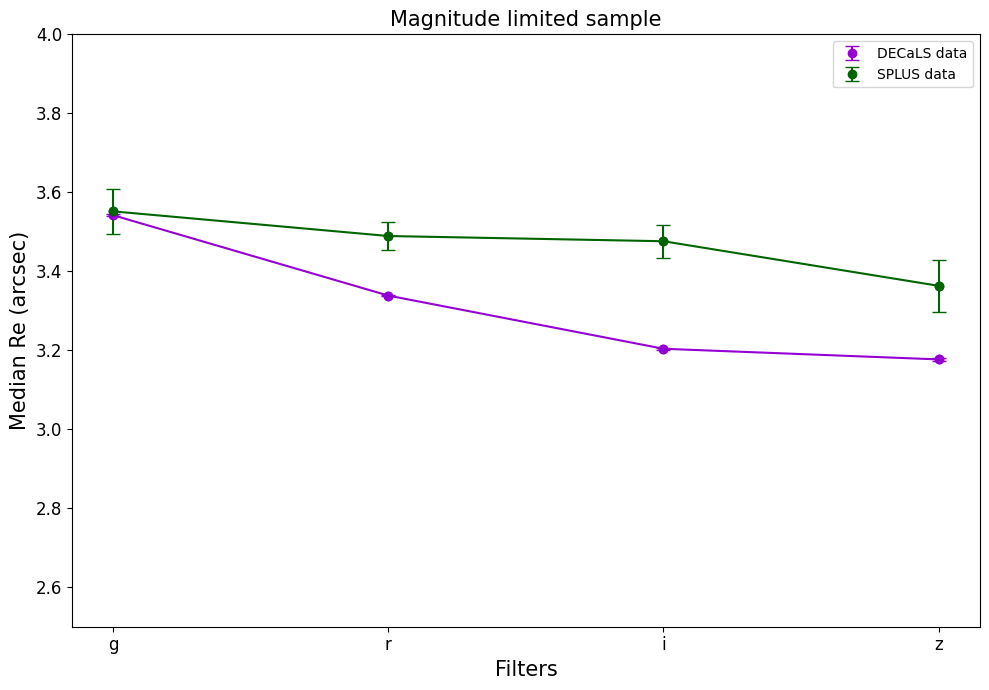

In [18]:
# Crear el gráfico de puntos con barras de error
plt.figure(figsize=(10, 7))

# Gráfico para valores_sersic con barras de error
plt.errorbar(filtros, medianas_valores_re, yerr=error_valores_re, fmt='o', capsize=5, color='darkviolet', label='DECaLS data')
plt.plot(filtros, medianas_valores_re, color='darkviolet', linestyle='-', marker='o')


# Gráfico para valores_sersic_splus con barras de error
plt.errorbar(filtros, medianas_valores_re_splus, yerr=error_valores_re_splus, fmt='o', capsize=5, color='darkgreen',label='SPLUS data')
plt.plot(filtros, medianas_valores_re_splus, color='darkgreen', linestyle='-', marker='o')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros, size=12)  # Etiquetas del eje x
plt.yticks(size=12)
plt.xlabel('Filters', size=15)
plt.ylabel('Median Re (arcsec)', size=15)
plt.title('Magnitude limited sample', size=15)
plt.legend()
plt.ylim(2.5, 4)

plt.tight_layout()

# Mostrar el gráfico
plt.show()

La mediana de la diferencias en Re: -0.3107, con mínimo en -21.423, y máximo 6.1976
La mediana de la diferencias en Re: -0.2768, con mínimo en -15.5794, y máximo 6.5458
La mediana de la diferencias en Re: -0.2905, con mínimo en -10.0268, y máximo 6.8782
La mediana de la diferencias en Re: -0.3638, con mínimo en -6.8831, y máximo 7.2485


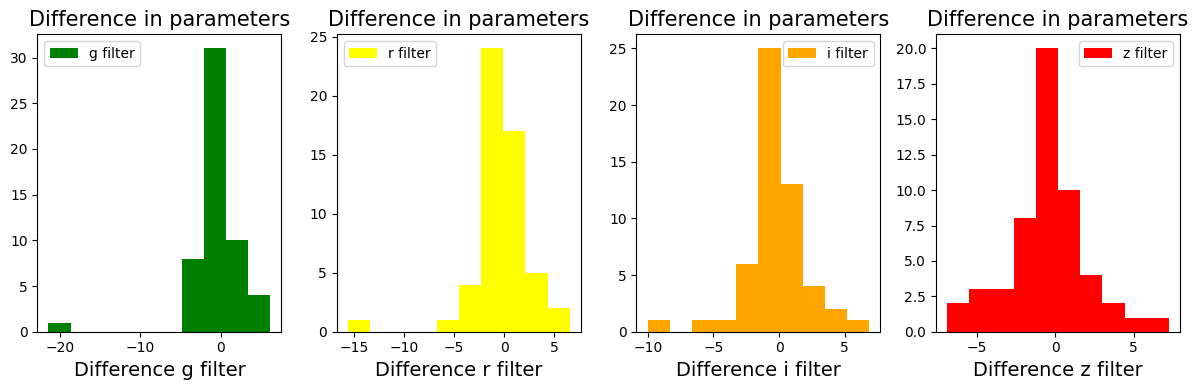

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
graficar_diferencias(axs[:], valores_re, valores_re_splus, 'green', 'yellow', 'orange', 'red', 'Re')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def bootstrap_mediana(valores, num_bootstrap=1000):
    """
    Calcula la mediana y el error de la mediana usando bootstrap.
    
    :param valores: array-like, valores sobre los que se calcula la mediana.
    :param num_bootstrap: int, número de muestras bootstrap.
    :return: mediana_bootstrap, error_bootstrap
    """
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0.0)]
    if len(valores_filtrados) == 0:
        print("NO HAY VALORES QUE CALCULAR")
        return np.nan, np.nan
    
    # Crear muestras bootstrap
    medianas_bootstrap = []
    for _ in range(num_bootstrap):
        muestra = np.random.choice(valores_filtrados, size=len(valores_filtrados), replace=True)
        medianas_bootstrap.append(np.nanmedian(muestra))
    
    # Calcular estadística final
    mediana_bootstrap = np.nanmedian(medianas_bootstrap)
    error_bootstrap = np.std(medianas_bootstrap)  # Puede usarse también el percentil para intervalos de confianza
    return mediana_bootstrap, error_bootstrap

In [21]:
# Calcular medianas y errores para cada filtro en 'valores_sersic'
resultados_sersic = [bootstrap_mediana(valores_sersic[i]) for i in range(len(filtros))]
medianas_valores_sersic = np.array([res[0] for res in resultados_sersic])
errores_valores_sersic = np.array([res[1] for res in resultados_sersic])

# Calcular medianas y errores para cada filtro en 'valores_sersic_splus'
resultados_sersic_splus = [bootstrap_mediana(valores_sersic_splus[i]) for i in range(len(filtros))]
medianas_valores_sersic_splus = np.array([res[0] for res in resultados_sersic_splus])
errores_valores_sersic_splus = np.array([res[1] for res in resultados_sersic_splus])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(f'{medianas_valores_sersic} ± {errores_valores_sersic}')

print("\nMedianas para valores_sersic_splus:")
print(f'{medianas_valores_sersic_splus} ± {errores_valores_sersic_splus}')

dif_g = abs(resultados_sersic[0][0] - resultados_sersic_splus[0][0])
dif_r = abs(resultados_sersic[1][0] - resultados_sersic_splus[1][0])
dif_i = abs(resultados_sersic[2][0] - resultados_sersic_splus[2][0])
dif_z = abs(resultados_sersic[3][0] - resultados_sersic_splus[3][0])

err_g = abs(resultados_sersic[0][1] - resultados_sersic_splus[0][1])
err_r = abs(resultados_sersic[1][1] - resultados_sersic_splus[1][1])
err_i = abs(resultados_sersic[2][1] - resultados_sersic_splus[2][1])
err_z = abs(resultados_sersic[3][1] - resultados_sersic_splus[3][1])

mean_dif = (dif_g + dif_r + dif_i + dif_z)/4
mean_error = (err_g + err_r + err_i + err_z)/4

print("\nDiferencia promedio:")
print(f'{mean_dif} ± {mean_error}')



Medianas para valores_sersic:
[0.9131 1.1301 1.2941 1.4249] ± [0.0627474  0.07369776 0.08550905 0.08425365]

Medianas para valores_sersic_splus:
[0.9809  1.23995 1.41845 1.57585] ± [0.07875391 0.05007007 0.07239831 0.1131255 ]

Diferencia promedio:
0.11323749999999991 ± 0.020404197631952767


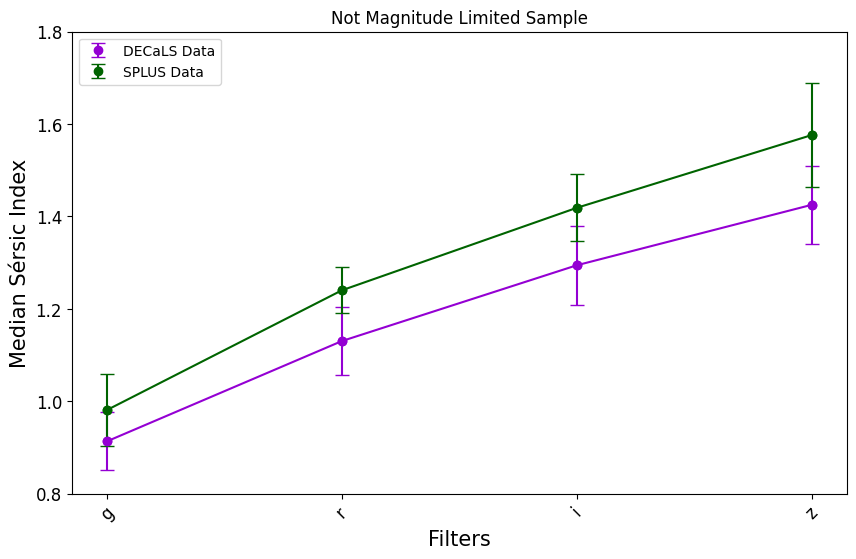

In [22]:
plt.figure(figsize=(10, 6))

# Grafica para valores_sersic
plt.errorbar(range(len(filtros)), medianas_valores_sersic, yerr=errores_valores_sersic,
             fmt='o', capsize=5, label='DECaLS Data', color='darkviolet')
plt.plot(filtros, medianas_valores_sersic, color='darkviolet', linestyle='-', marker='o')

# Grafica para valores_sersic_splus
plt.errorbar(range(len(filtros)), medianas_valores_sersic_splus, yerr=errores_valores_sersic_splus,
             fmt='o', capsize=5, label='SPLUS Data', color='darkgreen')
plt.plot(filtros, medianas_valores_sersic_splus, color='darkgreen', linestyle='-', marker='o')

# Configuración de la gráfica
plt.xticks(range(len(filtros)), filtros, rotation=45, size=12)
plt.yticks(size=12)
plt.ylim(0.8, 1.8)
plt.xlabel("Filters", size=15)
plt.ylabel("Median Sérsic Index", size=15)
plt.title("Not Magnitude Limited Sample")
plt.legend()
plt.show()

In [26]:
# Calcular medianas y errores para cada filtro en 'valores_re'
resultados_re = [bootstrap_mediana(valores_re[i]) for i in range(len(filtros))]
medianas_valores_re = np.array([res[0] for res in resultados_re])
errores_valores_re = np.array([res[1] for res in resultados_re])

# Calcular medianas y errores para cada filtro en 'valores_re_splus'
resultados_re_splus = [bootstrap_mediana(valores_re_splus[i]) for i in range(len(filtros))]
medianas_valores_re_splus = np.array([res[0] for res in resultados_re_splus])
errores_valores_re_splus = np.array([res[1] for res in resultados_re_splus])

# Imprimir resultados
print("Medianas para valores_re:")
print(f'{medianas_valores_re} ± {errores_valores_re}')

print("\nMedianas para valores_re_splus:")
print(f'{medianas_valores_re_splus} ± {errores_valores_re_splus}')

dif_g = abs(resultados_re[0][0] - resultados_re_splus[0][0])
dif_r = abs(resultados_re[1][0] - resultados_re_splus[1][0])
dif_i = abs(resultados_re[2][0] - resultados_re_splus[2][0])
dif_z = abs(resultados_re[3][0] - resultados_re_splus[3][0])

err_g = abs(resultados_re[0][1] - resultados_re_splus[0][1])
err_r = abs(resultados_re[1][1] - resultados_re_splus[1][1])
err_i = abs(resultados_re[2][1] - resultados_re_splus[2][1])
err_z = abs(resultados_re[3][1] - resultados_re_splus[3][1])

mean_dif_re = (dif_g + dif_r + dif_i + dif_z)/4
mean_error_re = (err_g + err_r + err_i + err_z)/4

print("\nDiferencia promedio:")
print(f'{mean_dif_re} ± {mean_error_re}')
print(dif_g, dif_r, dif_i, dif_z)

Medianas para valores_re:
[3.5177954 3.3384957 3.2182508 3.1768548] ± [0.18191642 0.20796278 0.25056511 0.27348146]

Medianas para valores_re_splus:
[3.5517625 3.48931   3.4760825 3.3631675] ± [0.27140044 0.22867001 0.25009331 0.26480833]

Diferencia promedio:
0.15723145000000016 ± 0.02983404518320254
0.03396710000000036 0.1508143000000004 0.2578317000000001 0.18631269999999978


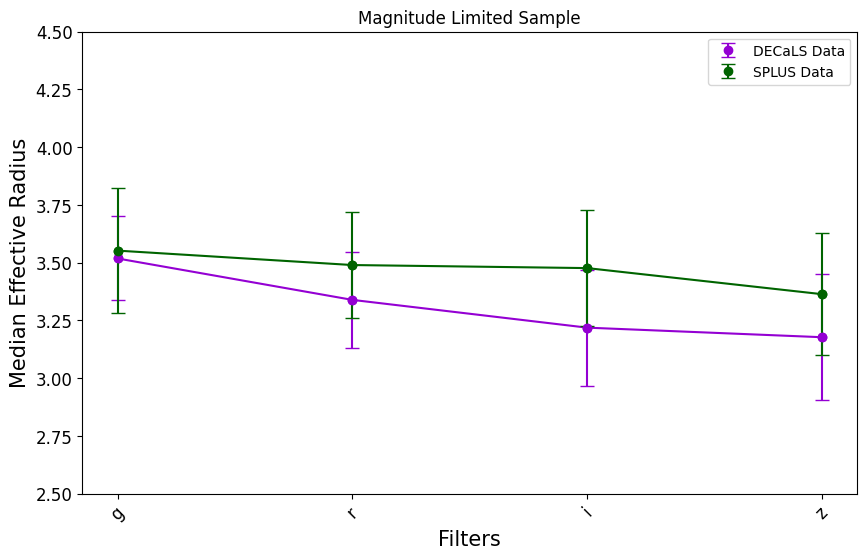

In [27]:
plt.figure(figsize=(10, 6))

# Grafica para valores_sersic
plt.errorbar(range(len(filtros)), medianas_valores_re, yerr=errores_valores_re,
             fmt='o', capsize=5, label='DECaLS Data', color='darkviolet')
plt.plot(filtros, medianas_valores_re, color='darkviolet', linestyle='-', marker='o')

# Grafica para valores_sersic_splus
plt.errorbar(range(len(filtros)), medianas_valores_re_splus, yerr=errores_valores_re_splus,
             fmt='o', capsize=5, label='SPLUS Data', color='darkgreen')
plt.plot(filtros, medianas_valores_re_splus, color='darkgreen', linestyle='-', marker='o')

# Configuración de la gráfica
plt.xticks(range(len(filtros)), filtros, rotation=45, size=12)
plt.yticks(size=12)
plt.ylim(2.5, 4.5)
plt.xlabel("Filters", size=15)
plt.ylabel("Median Effective Radius", size=15)
plt.title("Magnitude Limited Sample")
plt.legend()
plt.show()

In [40]:
from astropy.cosmology import FlatLambdaCDM
import numpy as np
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

# angular diameter distance in Mpc
d_A = cosmo.angular_diameter_distance(z=0.17)
theta = 0.03 # arcsec

# pi radian = 180 degree ==> 1deg = pi/180 ==> 1arcsec = pi/180/3600
theta_radian = theta * np.pi / 180 / 3600

# arc length = radius * angle
distance_kpc = d_A.to(u.kpc) * theta_radian

print(distance_kpc)

0.08967365567268266 kpc


In [25]:
u_r_o = filtered_splus['MAG_g'] - filtered_splus['MAG_r']
g_r_model = model['mag_g'] - model['mag_r']
plt.scatter(filtered_splus['n_r'], u_r_o, marker='.', color= 'darkviolet', label='SPLUS data')
plt.scatter(model['n_r'], g_r_model, marker='.', color='plum', label='DECaLS data')

#plt.ylim(-3, 5)
#plt.xlim(0, )
plt.title('Color vs Sérsic index')
plt.xlabel('n(r)')
plt.ylabel('g-r')
# Añadir una línea horizontal en y=50
plt.legend()
plt.axhline(y=0.67, color='teal', linestyle='--')

# Añadir una línea vertical en x=2.5
plt.axvline(x=2.5, color='teal', linestyle='--')
plt.show()

NameError: name 'filtered_splus' is not defined

In [ ]:
decals_data = Table.read('GalfitM_DECALS_SPLUS_25_2.csv')
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals_data['n_' + filtro] = pd.to_numeric(decals_data['n_' + filtro], errors='coerce')
    decals_data['RE_' +filtro] = pd.to_numeric(decals_data['RE_' + filtro], errors = 'coerce')

In [ ]:
grouped_decals = model.group_by('Group')

valid_groups=[]

for group in grouped_decals.groups:
    if any (group['zmemb'] != 0):
        valid_groups.append(group['Group'][0])

filtered_table = model[np.isin(model['Group'], valid_groups)]
filtered_table

In [ ]:
# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb'][group['zmemb'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group').groups:
    result_groups.append(replace_zeros(group))

final_table = vstack(result_groups)

final_table

$log SFR_{NUV} (M_{\odot}yr^{-1}) = log L_{NUV}, corr(L_{\odot}) -9.33$


$log SFR_{FUV} (M_{\odot}yr^{-1}) = log L_{FUV}, corr(L_{\odot}) -9.51$

$A_{NUV} = -0.0495x^{3} + 0.4718x^{2} + 0.8998x + 0.2269$

$A_{FUV} = -0.0333y^{3} + 0.3522y^{2} + 1.1960y + 0.4967$


In [ ]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table['Distance (Mpc)'] = (final_table['zmemb']*c)/H_0
final_table

### Para calcular magnitud absoluta, utilizamos el módulo de distancia
$m - M = 5log(\frac{D}{1pc}) - 5$
### Para luego obtener la Luminosidad mediante
$L_{x} = 10^{-0.4(M_{x}-M_{\odot, x})}L_{\odot, x}$

### O también con flujo
$m_{x} = -2.5log(F) - 48.6$

## $F = 10^{-\frac{(m_{x} + 48.6)}{2.5}}$

$L = 4\pi D^2 F$


In [ ]:
def calcular_ssfr(archivo):
    H_0 = 67.4 #km/s/Mpc
    c = 300000
    L_sun = 3.83*10**33
    eta_fuv = 1.98e+15
    eta_nuv = 1.32e+15
    eta_w3 = 2.5e+13
    eta_w4 = 1.25e+13

    archivo['Distance (Mpc)'] = (archivo['zmemb']*c)/H_0
    archivo['M_FUV'] = archivo['FUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_NUV'] = archivo['NUV'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #Contiene transformación de sistema de referencia de Vega a AB
    #archivo['M_w3'] = archivo['mag_w3'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    #archivo['M_w4'] = archivo['mag_w4'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5
    archivo['M_z'] = archivo['MAG_z'] - 5*np.log10(archivo['Distance (Mpc)']*1000000) + 5

    
    archivo['F_FUV'] = 10**(-(archivo['FUV']+48.6)/2.5)*eta_fuv
    archivo['F_NUV'] = 10**(-(archivo['NUV']+48.6)/2.5)*eta_nuv
    #archivo['F_w3'] = 10**(-(archivo['mag_w3']+48.6)/2.5)*eta_w3
    #archivo['F_w4'] = 10**(-(archivo['mag_w4']+48.6)/2.5)*eta_w4
    archivo['L_FUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_FUV']
    archivo['L_NUV'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_NUV']
    #archivo['L_w3'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w3']
    #archivo['L_w4'] = 4*np.pi*((archivo['Distance (Mpc)']*3.086*10**24)**2)*archivo['F_w4']

    SFR_NUV=[]
    SFR_FUV=[]
    L=[]
    anuv=[]
    afuv=[]
    for i in range(len(archivo)):
        #Razón entre L_IR y L_FUV, NUV para la correción por polvo
        #x_nuv = np.log10(archivo['F_w4'][i]/archivo['F_NUV'][i])
        #y_fuv = np.log10(archivo['F_w4'][i]/archivo['F_FUV'][i])
        #Calculando A_nuv y A_fuv 
        #a_nuv = -0.0495*x_nuv**3 + 0.4718*x_nuv**2 + 0.8998*x_nuv + 0.2269
        #a_fuv = -0.0333*y_fuv**3 + 0.3522*y_fuv**2 + 1.1960*y_fuv + 0.4967

        #Calculando el flujo corregido por polvo
        #F_FUV = 10**(-(archivo['FUV'][i] - a_fuv + 48.6)/2.5)*eta_fuv
        F_NUV = 10**(-(archivo['NUV'][i] - 0.78 + 48.6)/2.5)*eta_nuv
        #Calculando la Luminosidad corregida en L_sun 
        #L_FUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_FUV)/L_sun
        L_NUV_cor = (4*np.pi*((archivo['Distance (Mpc)'][i]*3.086e+24)**2)*F_NUV)/L_sun
        #L.append(L_FUV_cor)
        #Calculando la SFR en FUV y NUV
        #sfr_FUV = np.log10(L_FUV_cor) - 9.51
        sfr_NUV = np.log10(L_NUV_cor) - 9.33

        #anuv.append(a_nuv)
        #afuv.append(a_fuv)
        SFR_NUV.append(sfr_NUV)
        #SFR_FUV.append(sfr_FUV)

    archivo['logSFR_NUV'] = SFR_NUV
    #archivo['logSFR_FUV'] = SFR_FUV
    #print(anuv)
    #print(afuv)
    #print(min(anuv), max(anuv))
    #print(min(afuv), max(afuv))
    archivo['log(M_*)_z'] = (1.15 + 0.7*(archivo['MAG_g'] - archivo['MAG_z']) - 0.4*archivo['M_z'])*u.M_sun
    archivo['log_sSFR'] = archivo['logSFR_NUV'] - archivo['log(M_*)_z']
    return archivo
    
def filtrado(archivo):
    grouped = archivo.group_by('Group')

    valid_groups=[]

    for group in grouped.groups:
        if any (group['zmemb'] != 0):
            valid_groups.append(group['Group'][0])

    filtered_table = archivo[np.isin(archivo['Group'], valid_groups)]

    # Crear una función para reemplazar los valores de 'zmemb' que son 0
    def replace_zeros(group):
        non_zero_values = group['zmemb'][group['zmemb'] != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
        return group

    # Aplicar la función a cada grupo y unir los resultados
    result_groups = []
    for group in filtered_table.group_by('Group').groups:
        result_groups.append(replace_zeros(group))

    final_table = vstack(result_groups)

    # Función para verificar si un valor es numérico
    def is_number(value):
        try:
            float(value)
            return True
        except (ValueError, TypeError):
            return False

    # Convertir los valores enmascarados a string y eliminar espacios en blanco
    #final_table['mag_w4'] = [str(x).strip() for x in final_table['mag_w4']]

    # Crear una máscara booleana para los valores numéricos
    #mask = [is_number(x) for x in final_table['mag_w4']]

    # Aplicar la máscara para filtrar la tabla
    #final_table = final_table[mask]

    # Convertir la columna a tipo flotante
    #final_table['mag_w4'] = final_table['mag_w4'].astype(float)

    # Eliminar filas con valores NaN
    #final_table = final_table[~np.isnan(final_table['mag_w4'])]

    # Eliminar filas con valores infinitos
    #final_table = final_table[np.isfinite(final_table['mag_w4'])]
    #archivo = final_table
    archivo = final_table

    return archivo

In [ ]:
len(filtrado(model))

In [ ]:
model_ssfr = calcular_ssfr(filtrado(model))
model_ssfr = model_ssfr['Group', 'Gal', 'zmemb', 'ra', 'dec', 'logSFR_NUV', 'log_sSFR', 'log(M_*)_z', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z']
survey_column = Column(['DECALS'] * len(model_ssfr), name='Survey')

model_ssfr.add_column(survey_column)
len(model_ssfr)
model_ssfr.write('decals_for_plots', format='csv', overwrite=True)

In [ ]:
splus_ssfr = calcular_ssfr((filtrado(splus)))
splus_ssfr = splus_ssfr['Group', 'Gal', 'zmemb', 'ra', 'dec', 'logSFR_NUV', 'log_sSFR', 'log(M_*)_z', 'RE_g', 'n_g', 'RE_r', 'n_r', 'RE_i', 'n_i', 'RE_z', 'n_z']
survey_column = Column(['SPLUS'] * len(splus_ssfr), name='Survey')

splus_ssfr.add_column(survey_column)
len(splus_ssfr)
#splus_ssfr.write('splus_for_plots', format='csv', overwrite=True)

In [ ]:
median_ssfr_splus = np.nanmedian(splus_ssfr['log_sSFR'])
print(median_ssfr_splus)

In [ ]:
median_sfr = np.nanmedian(model_ssfr['logSFR_NUV'])
median_ssfr = np.nanmedian(model_ssfr['log_sSFR'])
print(median_sfr, median_ssfr)
for colname in model_ssfr.colnames:
    data = model_ssfr[colname]
    # Verificar si la columna es de tipo numérico
    if np.issubdtype(data.dtype, np.number):
        # Reemplazar inf y -inf por NaN solo en columnas numéricas
        data = np.where(np.isinf(data), np.nan, data)
        # Actualizar la columna en la tabla
        model_ssfr[colname] = data
model_ssfr

In [ ]:
decals_plots=Table.read('decals_for_plots', format='ascii')
splus_plots = Table.read('splus_for_plots', format='ascii')

decals_splus = vstack([decals_plots, splus_plots])
# Aplicar la condición para la columna 'Survey'
decals_splus['RE_g'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_g']*0.55, decals_splus['RE_g']*0.262)

decals_splus['RE_r'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_r']*0.55, decals_splus['RE_r']*0.262)

decals_splus['RE_z'] = np.where(decals_splus['Survey'] == 'SPLUS', decals_splus['RE_z']*0.55, decals_splus['RE_z']*0.262)

H_0 = 67.4 #km/s/Mpc

decals_splus['Distance (Mpc)'] = (decals_splus['zmemb']*300000)/H_0
decals_splus['RE_g(kpc)'] = (decals_splus['RE_g']*decals_splus['Distance (Mpc)'])/206.265
decals_splus['RE_r(kpc)'] = (decals_splus['RE_r']*decals_splus['Distance (Mpc)'])/206.265
decals_splus['RE_z(kpc)'] = (decals_splus['RE_z']*decals_splus['Distance (Mpc)'])/206.265

decals_splus = decals_splus[~np.isnan(decals_splus['RE_g(kpc)'])]
len(decals_splus[decals_splus['Survey'] == 'DECALS'])
#decals_splus[decals_splus['RE_g(kpc)']>15]

In [ ]:
median_n = np.nanmedian(decals_splus['n_r'][decals_splus['Survey']=='SPLUS'])
median_re = np.nanmedian(decals_splus['RE_r(kpc)'][(decals_splus['Survey']=='DECALS') & (decals_splus['log(M_*)_z'] > 10)])
#median_sfr = np.median(decals_splus['logSFR_NUV'])
#median_ssfr = np.median(decals_splus['log_sSFR'])
print(median_re, median_n)

In [ ]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['log_sSFR']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)

In [ ]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['logSFR_NUV']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)

In [ ]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
sns.set_palette("pastel")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

# Definir los datos
x = decals_splus['log_sSFR']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['n_g', 'n_r', 'n_z']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,# Llenar las curvas para mejor visualización
        palette=custom_palette
        #alpha=0.6
    ).set_axis_labels("log_sSFR", f"{col}")
    
    plt.show()  # Mostrar cada gráfico por separado


In [ ]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}
# Definir los datos
x = decals_splus['log_sSFR']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # Llenar las curvas para mejor visualización
        palette=custom_palette
    ).set_axis_labels("log_sSFR", f"{col}")
    
    plt.show()  # Mostrar cada gráfico por separado

In [ ]:
# Configurar el estilo de Seaborn
sns.set_theme(style="ticks")
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}
# Definir los datos
x = decals_splus['log(M_*)_z']
sur = decals_splus['Survey']

# Lista de columnas que quieres graficar
y_columns = ['RE_g(kpc)', 'RE_r(kpc)', 'RE_z(kpc)']

# Iterar sobre las columnas y crear un gráfico conjunto para cada una
for col in y_columns:
    sns.jointplot(
        data=decals_splus,
        x=x, y=decals_splus[col], hue=sur,
        kind="kde",  # Tipo de gráfico (kde para estimación de densidad)
        fill=False,  # Llenar las curvas para mejor visualización
        palette=custom_palette
    ).set_axis_labels("$M_{*}(M_{\odot})$", f"{col}")
    #plt.xlim(8, 11.5)
    #plt.ylim(-1, 30)
    plt.show()

In [ ]:
custom_palette = {'DECALS': 'plum', 'SPLUS': 'darkviolet'}

sns.set_theme(style="ticks")
#sns.set_palette("pastel")
y=decals_splus['RE_g(kpc)']
x=decals_splus['log(M_*)_z']
sur=decals_splus['Survey']

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=decals_splus,
    x=x, y=y, hue=sur,
    kind="kde",
    fill=False,
    palette=custom_palette
    #alpha=0.6
)